Construct a set of mock observations (with photometry and rest-frame optical spectroscopy matching that available for DF44 in Webb+2022) for a galaxy of a given SFH.

I've written the build_model to use a nonparametric SFH model for which the fraction of SFR in each time bin can be specified.
For the mock SFHs discussed here, the form follows a constant + immediate quench form.
Prospector/FSPS does provide a model for such SFHs, however I've just kept things general here.

In [1]:
# imports 
import numpy as np
import matplotlib.pyplot as plt

import sedpy # sometimes get an error if sedpy is imported before prospect, so use this ordering
import h5py

from prospect.sources.constants import cosmo 
from astropy.cosmology import z_at_value
import astropy.units as u

In [2]:
# true values for mock data

zobs = 0.02142
tuniv = cosmo.age(zobs).value

theta_truth = dict(
                    zobs = zobs,
    
                    # stellar population properties
                    logmass = 8.5, # np.log10( 1.6e11 ),
                    logzsol = -1.2,
                    dust2 = 0.01,
    
                    # spectral resolution
                    sigma_smooth = 110, # km/s
                    smoothtype = 'vel',
                    inres = ( 3e5 ) * (2.5/2.355 / 5000), # 64 km/s
                    )

In [3]:
# Define fixed age bins

nbins_sfh =  200

agelims = [1e-9]
agelims += np.linspace( 0.03, 0.95*tuniv, nbins_sfh-1 ).tolist()
agelims += [tuniv]

# convert to units of log(t/yr)
agelims = np.log10( np.array(agelims) * 1e9)

# convert from list of bin edges to to array of bins
agebins_sfh = np.array([agelims[:-1], agelims[1:]]).T

agebins_sfh_Gyr = np.power( 10, agebins_sfh-9 )

theta_truth['nbins'] = nbins_sfh
theta_truth['agebins'] = agebins_sfh

In [5]:

from Dragonfly44_SFH.utils.transforms import zfrac_to_sfr, sfr_to_mwa

def build_model( theta_truth, do_smoothing=True, **extras):
    
    from prospect.models import priors, sedmodel
    import prospect.models.transforms as ptransforms
    from prospect.models.templates import TemplateLibrary
    from Dragonfly44_SFH.utils.transforms import zfrac_to_masses


    nbins = theta_truth['nbins']

    imf = {"N":1, "isfree":False, "init": 1 } # Chabrier
    #dust_type = {"N":1, "isfree":False, "init":1 } # 1 MW like, MWR=3.1 (defualt), uvb=1 (default)
    dust_type = {"N":1, "isfree":False, "init":4 } # FSPS flexible Calzetti
    sfh = {"N": 1, "isfree": False, "init": 3, "units": "FSPS index"} # Sets nonparametric SFH

    # SSP parameters

    zred = {"N": 1, "isfree": True,
            "init": theta_truth['zobs'],
            "units": "redshift",
            "prior": priors.TopHat(mini=zobs-0.001, maxi=zobs+0.001) }

    total_mass = {"N": 1, "isfree": True,
                  "init": np.power(10, theta_truth['logmass']),
                  "units": "Solar masses formed",
                  "prior": priors.LogUniform(mini=1e8, maxi=1e12)}

    mass = {"N": nbins, "isfree": False,
            "init": 1.,
            "units": "Solar masses formed",
            "prior": priors.LogUniform(mini=1e8, maxi=1e12),
            "depends_on": zfrac_to_masses } # if defining SFH in terms of z_fraction or sfr_fraction

    logzsol = {"N": 1, "isfree": True,
               "init": theta_truth['logzsol'],
               "units": r"$\log (Z/Z_\odot)$",
               "prior": priors.TopHat(mini=-2, maxi=0.19) }

    dust2 = {"N": 1, "isfree": True,
             "init":  theta_truth['dust2'],
             "units": "optical depth at 5500AA",
             "prior": priors.TopHat(mini=0.0, maxi=2.0) }

    # This gives the start and stop of each age bin.  It can be adjusted and its
    # length must match the lenth of "mass"
    #agebins = build_agebins(redshift=zobs, ncomp=nbins)
    bins = {'N': nbins, 'isfree': False,
            'init': theta_truth['agebins'],
            'units': 'log(yr)'}

    # Rather than work with z_fraction, define explicity the sfr fraction
    sfrac = {"N": nbins, "isfree": True,
             "init": np.ones(nbins)/np.sum(nbins),
             "prior": priors.TopHat(mini=np.zeros(nbins), maxi=np.ones(nbins))}


    # model parameters dictionary
    model_params = {"imf_type": imf,
                    "dust_type": dust_type,
                    "sfh": sfh,
                    "zred": zred,
                    "mass": mass,
                    "total_mass": total_mass,
                    "logzsol": logzsol,
                    "dust2": dust2,
                    "agebins": bins,
                    "sfr_fraction": sfrac,
                   }

    model_params.update(TemplateLibrary["dust_emission"])
    model_params["duste_umin"]["init"] = 12.5
    model_params["duste_qpah"]["init"] = 3.25
    model_params["duste_gamma"]["init"] = 0.01

    model_params["dust1"]      = {"N": 1, "isfree": False, 'depends_on': ptransforms.dustratio_to_dust1,
                                  "init": 0.0, "units": "optical depth towards young stars"}

    model_params["dust_ratio"] = {"N": 1, "isfree": True,
                                  "init": 1.0, "units": "ratio of birth-cloud to diffuse dust",
                                  "prior": priors.ClippedNormal(mini=0.0, maxi=2.0, mean=1.0, sigma=0.3)}

    model_params["dust_index"] = {"N": 1, "isfree": True,
                                  "init": 0.0, "units": "power-law multiplication of Calzetti",
                                  "prior": priors.TopHat(mini=-2.0, maxi=0.5)}

    # initialize
    model = sedmodel.PolySpecModel(model_params)

    if do_smoothing:
        # convolve to observed resolution
        model.params['sigma_smooth'] = theta_truth['sigma_smooth']
        model.params['smoothtype'] = theta_truth['smoothtype']
        model.params['inres'] = theta_truth['inres']

    return model

def build_sps(**extras):
    """
    This is a class that wraps the fsps.StellarPopulation object, which is
    used for producing SSPs.  The ``fsps.StellarPopulation`` object is accessed
    as ``SSPBasis().ssp``.
    """
    from prospect.sources import FastStepBasis
    sps = FastStepBasis() # for nonparametric SFH
    return sps

model = build_model( theta_truth )

In [21]:
def read_input(file_data=None, galaxy_id=None, **extras):
    import h5py
    ddict = {}
    with h5py.File(file_data, 'r') as hfile:

        for key in ['wavelength',"Redshift","mass","sigma_smooth","e_sigma_smooth","inres",  "maggies","spectrum","maggies_unc","unc"]:
            v = np.copy( hfile[key] )
            if v.size>1:
                ddict[key] = v
            else:
                ddict[key] = v.item()

        for key in ['filternames']:
            ddict[key] = np.array( np.copy( hfile[key] ), dtype=str )

        key = "smoothtype"
        ddict[key] = np.copy( hfile[key] ).astype(str).item()

        try: ddict['mask'] = np.copy( hfile['mask'] )
        except: pass

    return ddict

def build_basic_obs( mock_obs_params, **extras ):

    obs = {}

    obs['spectrum'] = None
    obs['unc'] = None
    obs['wavelength'] = None
    obs['spec_norm'] = None
    obs['maggies'] = None
    obs['maggies_unc'] = None

    wavelength = mock_obs_params['wavelength']
    obs['wavelength'] = wavelength
    obs['mask'] = np.ones_like(wavelength, dtype=bool)

    filternames = mock_obs_params['filternames']
    phot_filters = sedpy.observate.load_filters(filternames)
    wave_phot = np.array([f.wave_effective for f in phot_filters])
    obs['filters'] = phot_filters
    obs['filternames'] = filternames
    obs['phot_wave'] = wave_phot
    obs['phot_mask'] = np.ones_like(wave_phot, dtype=bool)

    return obs

data_df44 = read_input( "../../data/Dragonfly44/obs_phot_specKCWI_sigma110.h5")
obs_mock = build_basic_obs( data_df44 )

In [8]:
def build_sfrac( agebins_Gyr, tquench ):
    nbins = len( agebins_Gyr[:,0] )
    sfrac = np.full( nbins, 1e-12 )

    if tquench>0:
        iquench = np.where( agebins_Gyr < tquench )[0][-1]
        sfrac[ iquench: ] = 1
        
    sfrac /= np.sum( sfrac )
    return sfrac
    
def plot_sfh( theta=None, model=None, color="limegreen", label=None, \
              fig=None, return_fig=False, **params ):
    if fig is None: fig, ax = plt.subplots(1,1,figsize=(8,4))
    else: ax = fig.get_axes()[0]
    if "color" not in params.keys(): params['color'] = 'limegreen'

    if model is not None:
        x = np.unique( np.power(10, model.params['agebins']-9) )
        y = zfrac_to_sfr( **model.params )[0]
    elif theta is not None:
        x = np.unique( np.power(10, theta['agebins']-9) )
        if "sfr" in theta.keys():
            y = np.copy( theta["sfr"] )
        elif "sfr_fraction" in theta.keys():
            if "total_mass" in theta.keys(): total_mass = np.copy( theta['total_mass'] )
            else: total_mass = 1.
            y = zfrac_to_sfr( total_mass=total_mass, sfr_fraction=np.copy( theta['sfr_fraction'] ), agebins=theta['agebins'] )[0]
        else:
            print("No SFH in theta")
            raise Exception
            
    y = np.append( y, y[-1] )
    ax.step( x, y, color=color, lw=2, ls='-', zorder=0.5, where='post', label=label)

    ax.set(xlim=[-0.1,x[-1]+0.1], yscale='log', xlabel='Lookback time  (Gyr)', ylabel=r'SFR / $M_\ast$ (yr$^{-1}$)')

    if return_fig: return fig
    else: plt.show()

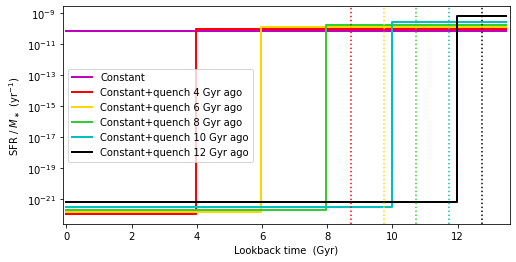

In [9]:
#
colors = ['m','r','gold','limegreen','c','k']

fig,ax = plt.subplots(1,1,figsize=(8,4))

fig = plot_sfh( label="Constant", \
                theta={"agebins":agebins_sfh, "sfr_fraction":build_sfrac( agebins_sfh_Gyr, 0 )}, \
                color=colors[0], return_fig=True, fig=fig )

for i,tq in enumerate([4,6,8,10,12]):
    col = colors[i+1]
    
    sfh_sfrac = build_sfrac( agebins_sfh_Gyr, tq )

    fig = plot_sfh( label="Constant+quench {} Gyr ago".format(tq),  \
                   theta={"agebins":agebins_sfh, 
                          "sfr_fraction":sfh_sfrac}, \
                   color=col, fig=fig, return_fig=True )
    
    
    sfr = zfrac_to_sfr( total_mass=1, sfr_fraction=sfh_sfrac, agebins=agebins_sfh )[0]
    mwa = sfr_to_mwa( sfrs=sfr, agebins=agebins_sfh )
    ax.axvline( mwa, ls=':', color=col )
    
ax = fig.get_axes()[0]
ax.legend()
plt.show()

In [56]:
sps = build_sps( )

def make_obs_for_constant_quench_sfh( tq, model, obs, theta_extras={}, npoly=2, spec_flat_norm=1e-8 ):
    theta_i = np.copy( model.initial_theta )
    theta_i[ model.theta_index['sfr_fraction'] ] = build_sfrac( np.power( 10, model.params['agebins']-9 ), tq )
    
    for k,v in theta_extras.items():
        theta_i[ model.theta_index[k] ] = v

    model.set_parameters( theta_i )
    model.propagate_parameter_dependencies()
    spec, phot, mfrac = model.predict( theta_i, obs=obs, sps=sps )
    
    x = obs['wavelength']
    coeffs = np.polyfit( x, spec, npoly )
    poly = np.poly1d( coeffs )( x )
    spec_flat = spec/poly
    spec_flat *= spec_flat_norm
    
    obs['maggies'] = phot
    obs['spectrum'] = spec
    obs['spectrum_wo_continuum'] = spec_flat
    obs['spec_norm'] = spec_flat_norm
    
    return obs

def plot_obs( obs, axes, color='limegreen', label=None ):
    
    if axes.size==2: ax_spec,ax_phot = axes ; ax_fspec=None
    elif axes.size==3: ax_spec,ax_fspec,ax_phot = axes
    else: print('axes shape unexpected') ; raise Exception

    x, y, mask = [ np.copy( obs[key] ) for key in [ "wavelength",'spectrum',"mask" ]]
    ax_spec.step( x, y, color=color, alpha=0.1, where='post', zorder=1)
    ax_spec.step( x[mask], y[mask], color=color, where='post', zorder=1, label=label)
    ax_spec.set( xlabel='Observed wavelength (AA)', yscale='log' )
    
    if ax_fspec is not None:
        y = np.copy( obs['spectrum_wo_continuum'] )
        ax_fspec.step( x, y, color=color, alpha=0.1, where='post', zorder=1)
        ax_fspec.step( x[mask], y[mask], color=color, where='post', zorder=1, label=label)
        ax_fspec.set( xlabel='Observed wavelength (AA)', yscale='log' )

    x, y, mask  = [ np.copy( obs[key] ) for key in [ "phot_wave",'maggies',"phot_mask" ]]
    ax_phot.scatter( x[~mask], y[~mask], color=color, marker='x', alpha=0.5 )
    ax_phot.scatter( x[mask], y[mask], color='None', edgecolor=color, marker='o', s=150)
    ax_phot.set( xlabel='Observed wavelength (AA)', xscale='log', yscale='log' )


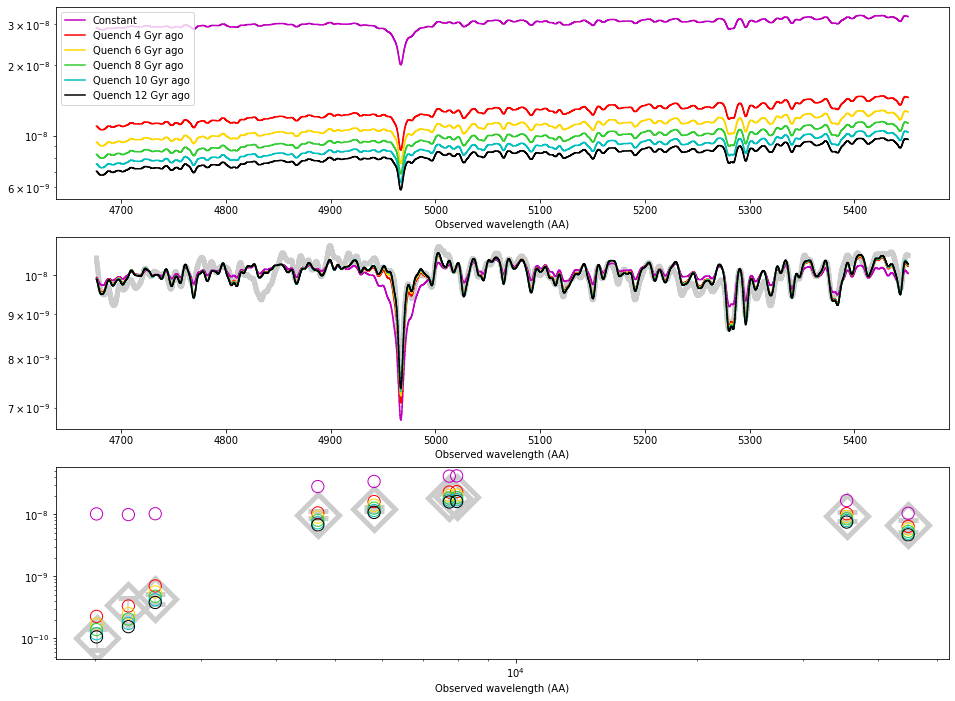

In [46]:
#
fig, axes = plt.subplots(3,1,figsize=(16,12))

plot_obs( make_obs_for_constant_quench_sfh( 0, model, obs_mock ), 
          color=colors[0], 
          label="Constant", 
          axes=axes )

for i,tq in enumerate([4,6,8,10,12]):
    
    plot_obs( make_obs_for_constant_quench_sfh( tq, model, obs_mock ), 
              color=colors[i+1], 
              label="Quench {} Gyr ago".format(tq), 
              axes=axes )
    
# dragonfly 44 for comparison
osbcol = '0.8'
x,y,ey = [ np.copy(data_df44[key]) for key in ['wavelength','spectrum','unc']]
axes[1].step( x, y, 
              label="Dragonfly 44 observations", 
              color=osbcol, lw=5, zorder=-1)

x = obs_mock['phot_wave']
y,ey = [ np.copy(data_df44[key]) for key in ['maggies','maggies_unc'] ]
axes[-1].errorbar( x, y, yerr=ey, 
                  marker='D', color=osbcol, mec=osbcol, mfc='None', ms=30, fmt=' ', mew=5, capsize=10, zorder=-1 )

axes[0].legend()
plt.show()

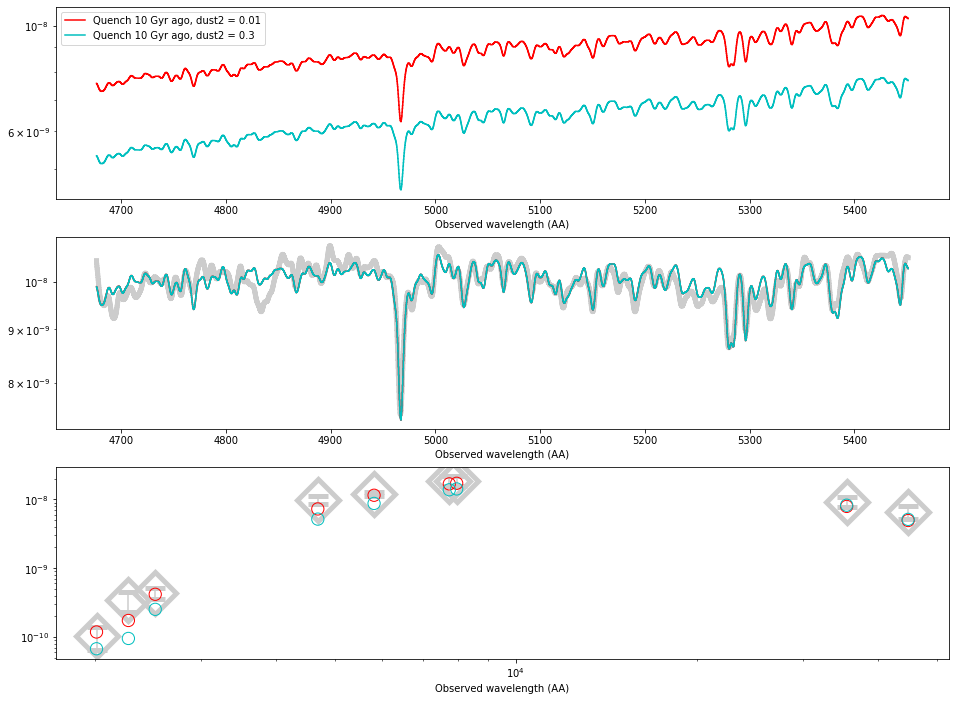

In [54]:
#
tq = 10

fig, axes = plt.subplots(3,1,figsize=(16,12))

dust2 = 0.01
plot_obs( make_obs_for_constant_quench_sfh( tq, model, obs_mock, theta_extras={'dust2':dust2} ), 
          label="Quench {} Gyr ago, dust2 = {}".format(tq, dust2), 
          axes=axes, color='r' )

dust2 = 0.3
plot_obs( make_obs_for_constant_quench_sfh( tq, model, obs_mock, theta_extras={'dust2':dust2} ), 
          label="Quench {} Gyr ago, dust2 = {}".format(tq, dust2), 
          axes=axes, color='c' )
    
# dragonfly 44 for comparison
osbcol = '0.8'
x,y,ey = [ np.copy(data_df44[key]) for key in ['wavelength','spectrum','unc']]
axes[1].step( x, y, 
              label="Dragonfly 44 observations", 
              color=osbcol, lw=5, zorder=-1)

x = obs_mock['phot_wave']
y,ey = [ np.copy(data_df44[key]) for key in ['maggies','maggies_unc'] ]
axes[-1].errorbar( x, y, yerr=ey, 
                  marker='D', color=osbcol, mec=osbcol, mfc='None', ms=30, fmt=' ', mew=5, capsize=10, zorder=-1 )

axes[0].legend()
plt.show()

In [63]:
from Dragonfly44_SFH.utils.h5py_utils import add_data

snr_phot = data_df44['maggies']/data_df44['maggies_unc']

def write_to_h5py( fname, obs, overwrite=False, snr_spec=1000, snr_phot=10 ):
    
    with h5py.File(fname,'a') as hf:
        for key,v in obs.items():

            if key in ["filters","unc","spectrum","maggies_unc"]: 
                continue
            elif key=="filternames":
                add_data( hf, key, v, string=True, overwrite=overwrite )
            else:
                add_data( hf, key, v, string=False, overwrite=overwrite )

            add_data( hf, "spectrum",    obs['spectrum_wo_continuum'], string=False, overwrite=overwrite )
            add_data( hf, "spectrum_w_continuum",    obs['spectrum'], string=False, overwrite=overwrite )
            add_data( hf, "unc",         obs['spectrum_wo_continuum']/snr_spec, string=False, overwrite=overwrite )
            add_data( hf, "maggies_unc", obs['maggies']/snr_phot,      string=False, overwrite=overwrite )

            for key in ["inres","sigma_smooth","smoothtype"]:
                add_data( hf, key, theta_truth[key],  string=False, overwrite=overwrite )
            add_data( hf, "e_sigma_smooth", 10,  string=False, overwrite=overwrite )

            add_data( hf, "Redshift", theta_truth["zobs"],     string=False, overwrite=overwrite )
            #add_data( hf, "mass", np.power(10, theta_truth["logmass"]),     string=False, overwrite=overwrite )
            

In [61]:
write_to_h5py( 'mock_obs_constant.h5', make_obs_for_constant_quench_sfh( 0, model, obs_mock ), snr_phot=snr_phot )    

for tq in [4,6,8,10,12]:
    write_to_h5py( 'mock_obs_quench_{}GyrAgo.h5'.format(tq), 
                   make_obs_for_constant_quench_sfh( tq, model, obs_mock ), snr_phot=snr_phot )    

